##

# Mile stone project 1: Food vision

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-30b05b2a-fefc-1282-c7a8-27d4e50eb0b6)


## Get helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-01-04 09:01:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-04 09:01:37 (60.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Get data from tensorflow datasets

In [4]:
import tensorflow_datasets as tfds

In [5]:
datasets = tfds.list_builders()

In [6]:
(train_data,test_data),ds_info = tfds.load(name="food101",
                                           split=["train","validation"],
                                           shuffle_files=True,
                                           as_supervised=True,
                                           with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete4YXX79/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete4YXX79/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data

train_one_sample = train_data.take(1)


In [10]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
for image,label in train_one_sample:
  print(image.shape)

(512, 512, 3)


In [12]:
image.shape

TensorShape([512, 512, 3])

In [13]:
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from tensorflow

(-0.5, 511.5, 511.5, -0.5)

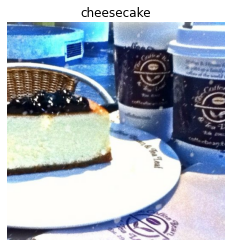

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [15]:
#make a function for preprocessing

def preprocess_img(image,label,image_shape=224):
  image = tf.image.resize(image,[image_shape,image_shape])
  return tf.cast(image,tf.float32),label

In [16]:
preprocessed_image = preprocess_img(image,label)[0]
preprocessed_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 84.67857 ,  84.321434,  92.321434],
        [ 87.19898 ,  86.841835,  94.841835],
        [ 84.72959 ,  84.581635,  94.72449 ],
        ...,
        [119.50503 , 194.93877 , 245.85202 ],
        [114.974525, 190.97452 , 241.90309 ],
        [119.071465, 196.4286  , 247.82652 ]],

       [[ 75.647964,  84.21939 ,  93.21939 ],
        [ 71.45407 ,  80.959175,  89.959175],
        [ 78.03061 ,  87.20408 ,  97.47449 ],
        ...,
        [113.31632 , 182.62755 , 249.35715 ],
        [106.57655 , 176.86227 , 245.4337  ],
        [108.601944, 179.9796  , 248.16833 ]],

       [[129.9949  , 152.06633 , 171.49492 ],
        [149.87756 , 171.94899 , 192.66328 ],
        [156.43878 , 178.29593 , 201.22449 ],
        ...,
        [127.94895 , 184.08676 , 236.39796 ],
        [129.41847 , 186.4899  , 238.41847 ],
        [132.56607 , 191.07118 , 243.63744 ]],

       ...,

       [[ 68.23475 ,  72.091934,  90.73993 ],
        [ 67.

In [17]:
#batch and & prepare dataset

In [18]:
train_data = train_data.map(preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Training callbacks

In [41]:
#creat model checkpoint callbacks

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [21]:
## Mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Create a baseline model

In [42]:
from tensorflow.keras import layers

input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape,name="input_layer")

x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float2")(x)

model = tf.keras.Model(inputs,outputs)

#Compile model

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [39]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float2 (Activation)  (None, 101)              0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
___________________________________________

In [24]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float2 True float32 <Policy "float32">


In [25]:
layer.weights

[]

In [26]:
for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [43]:
hist_0 = model.fit(train_data,
          epochs=3,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[create_tensorboard_callback("food_vision_101","base_line_model"),model_checkpoint])

Saving TensorBoard log files to: food_vision_101/base_line_model/20220104-092938
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 157s 63ms/step - loss: 1.8234 - accuracy: 0.5561 - val_loss: 1.2385 - val_accuracy: 0.6737
Epoch 2/3
2368/2368 [==============================] - 151s 63ms/step - loss: 1.2940 - accuracy: 0.6666 - val_loss: 1.1277 - val_accuracy: 0.6976
Epoch 3/3
2368/2368 [==============================] - 141s 59ms/step - loss: 1.1435 - accuracy: 0.7021 - val_loss: 1.0858 - val_accuracy: 0.7074


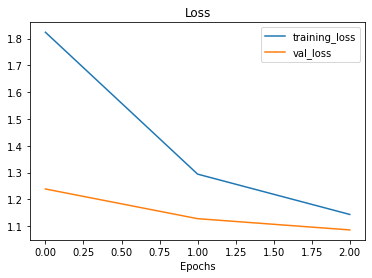

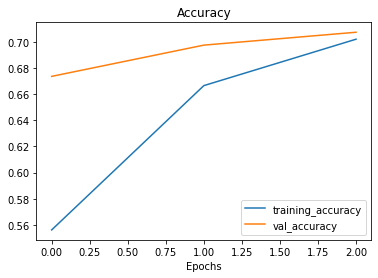

In [44]:
plot_loss_curves(hist_0)

In [45]:
for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [46]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [47]:
for layer in base_model.layers:
  print(layer.name,layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [89]:
loaded_model = tf.keras.models.load_model("/content/model_checkpoints")

OSError: ignored

In [49]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [50]:
model.fit(train_data,
          epochs=10,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          initial_epoch=hist_0.epoch[-1],
          callbacks=[create_tensorboard_callback("food_vision_101","base_line_model")])

Saving TensorBoard log files to: food_vision_101/base_line_model/20220104-093806
Epoch 3/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 168s 67ms/step - loss: 0.9469 - accuracy: 0.7501 - val_loss: 0.9971 - val_accuracy: 0.7262
Epoch 4/10
2368/2368 [==============================] - 147s 61ms/step - loss: 0.8000 - accuracy: 0.7877 - val_loss: 0.9726 - val_accuracy: 0.7341
Epoch 5/10
2368/2368 [==============================] - 145s 61ms/step - loss: 0.6908 - accuracy: 0.8178 - val_loss: 0.9663 - val_accuracy: 0.7368
Epoch 6/10
2368/2368 [==============================] - 144s 60ms/step - loss: 0.5965 - accuracy: 0.8426 - val_loss: 0.9715 - val_accuracy: 0.7379
Epoch 7/10
2368/2368 [==============================] - 148s 62ms/step - loss: 0.5130 - accuracy: 0.8656 - val_loss: 0.9861 - val_accuracy: 0.7379
Epoch 8/10
2368/2368 [==============================] - 146s 61ms/step - loss: 0.4392 - accuracy: 0.8877 - val_loss: 1.0062 - val_accuracy: 0.7381
Epoch 9/10
2368/2368 [==============================] - 146s 61ms/step - loss: 0.3753 - accuracy: 0.9073 - val_loss: 1.0165 - val

In [68]:
data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(.2),
      layers.RandomZoom(.2)
])

In [69]:

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [70]:
input_shape=(224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = layers.Input(shape=input_shape,name="input_layer")

x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype=tf.float32,name="softmax_float2")(x)

model1 = tf.keras.Model(inputs,outputs)

#Compile model

model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [71]:
hist_2_0 = model1.fit(train_data,
          epochs=5,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[create_tensorboard_callback("food_vision_101","model1"),model_checkpoint])

Saving TensorBoard log files to: food_vision_101/model1/20220104-110957
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 183s 68ms/step - loss: 2.1982 - accuracy: 0.4698 - val_loss: 1.3809 - val_accuracy: 0.6329
Epoch 2/5
2368/2368 [==============================] - 150s 63ms/step - loss: 1.6975 - accuracy: 0.5703 - val_loss: 1.2697 - val_accuracy: 0.6615
Epoch 3/5
2368/2368 [==============================] - 148s 62ms/step - loss: 1.5784 - accuracy: 0.5971 - val_loss: 1.2114 - val_accuracy: 0.6740
Epoch 4/5
2368/2368 [==============================] - 149s 62ms/step - loss: 1.5018 - accuracy: 0.6133 - val_loss: 1.1862 - val_accuracy: 0.6786
Epoch 5/5
2368/2368 [==============================] - 160s 67ms/step - loss: 1.4519 - accuracy: 0.6242 - val_loss: 1.1741 - val_accuracy: 0.6817


In [72]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [73]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [74]:
hist_2_1 = model1.fit(train_data,
          epochs=10,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          initial_epoch=hist_2_0.epoch[-1],
          callbacks=[create_tensorboard_callback("food_vision_101","model1")])

Saving TensorBoard log files to: food_vision_101/model1/20220104-112454
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 177s 71ms/step - loss: 1.3141 - accuracy: 0.6567 - val_loss: 1.0904 - val_accuracy: 0.7045
Epoch 6/10
2368/2368 [==============================] - 156s 65ms/step - loss: 1.2113 - accuracy: 0.6799 - val_loss: 1.0603 - val_accuracy: 0.7121
Epoch 7/10
2368/2368 [==============================] - 156s 65ms/step - loss: 1.1389 - accuracy: 0.6970 - val_loss: 1.0372 - val_accuracy: 0.7171
Epoch 8/10
2368/2368 [==============================] - 156s 65ms/step - loss: 1.0836 - accuracy: 0.7107 - val_loss: 1.0188 - val_accuracy: 0.7223
Epoch 9/10
2368/2368 [==============================] - 155s 65ms/step - loss: 1.0396 - accuracy: 0.7207 - val_loss: 1.0079 - val_accuracy: 0.7245
Epoch 10/10
2368/2368 [==============================] - 167s 70ms/step - loss: 0.9945 - accuracy: 0.7311 - val_loss: 1.0105 - val_accuracy: 0.7213


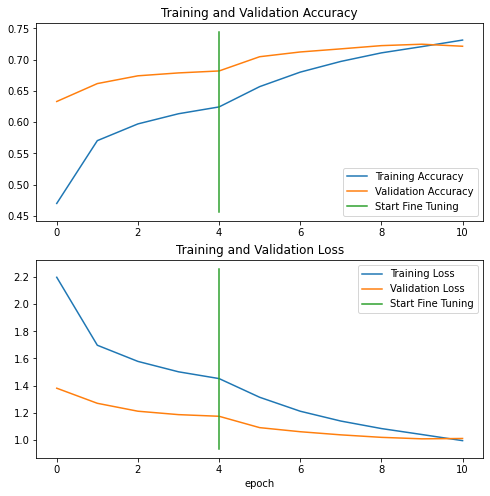

In [75]:
compare_historys(hist_2_0,hist_2_1)

In [78]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [79]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              metrics=["accuracy"])

In [80]:
hist_2_2 = model1.fit(train_data,
          epochs=15,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          initial_epoch=hist_2_1.epoch[-1],
          callbacks=[create_tensorboard_callback("food_vision_101","model1")])

Saving TensorBoard log files to: food_vision_101/model1/20220104-114406
Epoch 10/15


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 168s 67ms/step - loss: 0.9189 - accuracy: 0.7509 - val_loss: 0.9969 - val_accuracy: 0.7290
Epoch 11/15
2368/2368 [==============================] - 160s 67ms/step - loss: 0.8836 - accuracy: 0.7562 - val_loss: 1.0010 - val_accuracy: 0.7297
Epoch 12/15
2368/2368 [==============================] - 158s 66ms/step - loss: 0.8637 - accuracy: 0.7624 - val_loss: 1.0027 - val_accuracy: 0.7310
Epoch 13/15
2368/2368 [==============================] - 157s 66ms/step - loss: 0.8334 - accuracy: 0.7716 - val_loss: 0.9959 - val_accuracy: 0.7322
Epoch 14/15
2368/2368 [==============================] - 158s 66ms/step - loss: 0.8131 - accuracy: 0.7740 - val_loss: 1.0092 - val_accuracy: 0.7280
Epoch 15/15
2368/2368 [==============================] - 169s 71ms/step - loss: 0.7957 - accuracy: 0.7786 - val_loss: 1.0107 - val_accuracy: 0.7281


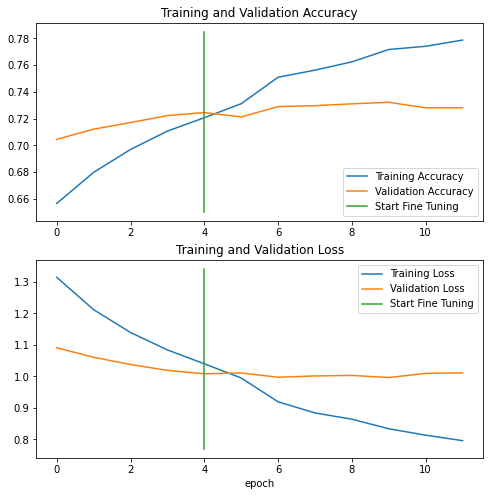

In [81]:
compare_historys(hist_2_1,hist_2_2)

In [82]:
base_model.trainable = True

for layer in base_model.layers[:-30]:
  layer.trainable = False

In [84]:
model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.000025),
              metrics=["accuracy"])

In [85]:
hist_2_3 = model1.fit(train_data,
          epochs=20,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=len(test_data),
          initial_epoch=hist_2_2.epoch[-1],
          callbacks=[create_tensorboard_callback("food_vision_101","model1")])

Saving TensorBoard log files to: food_vision_101/model1/20220104-120450
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 183s 73ms/step - loss: 0.7450 - accuracy: 0.7917 - val_loss: 1.0076 - val_accuracy: 0.7328
Epoch 16/20
2368/2368 [==============================] - 172s 72ms/step - loss: 0.7152 - accuracy: 0.7991 - val_loss: 0.9993 - val_accuracy: 0.7366
Epoch 17/20
2368/2368 [==============================] - 173s 72ms/step - loss: 0.6949 - accuracy: 0.8047 - val_loss: 1.0070 - val_accuracy: 0.7354
Epoch 18/20
1192/2368 [==============>...............] - ETA: 1:10 - loss: 0.6626 - accuracy: 0.8121

KeyboardInterrupt: ignored